# Sandbox

This is the Sandbox environment in which we can define and train ML models to test our hypothesis.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymongo import MongoClient

Retrieving books from MongoDB collection

In [2]:
my_client = MongoClient("mongodb://localhost:27017/")
my_db = my_client["goodreads_db"]
my_collection = my_db["books"]

# Retrieve all documents from events collection
documents = my_collection.find()
df = pd.DataFrame(documents).drop("_id", axis=1)
df.head()

,Title,Counter,Authors,Avg_Rating,Num_Pages,Ratings_Count,Text_Reviews_Count,Publisher,Publication_Date
0,$30 film school: how to write direct produce...,1,Michael W. Dean,3.49,528,30,4,Cengage Learning,2003-05-13
1,1 000 places to see before you die,1,Patricia Schultz,3.85,992,36303,439,Workman Publishing Company,2003-05-22
2,10 lb penalty,1,Dick Francis,3.90,320,3490,177,G.P. Putnam's Sons,2004-08-03
3,100 great fantasy short short stories,1,Isaac Asimov/Terry Carr/Martin H. Greenberg/Ja...,3.91,395,204,19,Avon,1985-08-01
4,100 love sonnets,1,Pablo Neruda/Stephen Tapscott,4.39,232,12613,392,University of Texas Press,1986-01-01


In [3]:
# Checking if all the data types are correct (MongoDB date type was not compatible with Spark's one)
df["Publication_Date"] = pd.to_datetime(df["Publication_Date"])

print(df.dtypes)

Title                         object
Counter                        int64
Authors                       object
Avg_Rating                   float64
Num_Pages                      int64
Ratings_Count                  int64
Text_Reviews_Count             int64
Publisher                     object
Publication_Date      datetime64[ns]
dtype: object


## MongoDB queries

Before building models, we wanted to see whether there was a significant and promising difference in average rating in relation with other features. To test this, we used two MongoDB queries showing the relations between average rating, publishers and authors.

In [4]:
# First query
pipeline=[
  {
    "$group" :
      {
        "_id" : "$Publisher",
        "total_books" : { "$sum" : 1 },
        "avg": { "$avg" :  "$Avg_Rating" }
      }
  },
  { "$sort" : { "total_books" : -1 } },
  { "$limit" : 5 },
  { "$sort" : { "avg" : -1 } }
]

result=my_collection.aggregate(pipeline)

print("Top 5 Most prolific Publishers sorted on AVG rating")
for doc in result:
  print(doc)

# Second query
pipeline=[
  {
    "$group" :
      {
        "_id" : "$Authors",
        "total_books" : { "$sum" : 1 },
        "avg": { "$avg" :  "$Avg_Rating" }
      }
  },
  { "$sort" : { "total_books" : -1 } },
  { "$limit" : 5 },
  { "$sort" : { "avg" : -1 } }
]

result=my_collection.aggregate(pipeline)

print("\nTop 5 Most prolific Authors sorted on AVG rating")
for doc in result:
  print(doc)

Top 5 Most prolific Publishers sorted on AVG rating
{'_id': 'Penguin Classics', 'total_books': 177, 'avg': 3.943841807909604}
{'_id': 'Penguin Books', 'total_books': 238, 'avg': 3.9255882352941174}
{'_id': 'Mariner Books', 'total_books': 133, 'avg': 3.9253383458646622}
{'_id': 'Vintage', 'total_books': 281, 'avg': 3.8971530249110318}
{'_id': 'Ballantine Books', 'total_books': 127, 'avg': 3.8696062992125984}

Top 5 Most prolific Authors sorted on AVG rating
{'_id': 'Rumiko Takahashi', 'total_books': 39, 'avg': 4.1866666666666665}
{'_id': 'P.G. Wodehouse', 'total_books': 40, 'avg': 4.14725}
{'_id': 'Agatha Christie', 'total_books': 33, 'avg': 3.989090909090909}
{'_id': 'Stephen King', 'total_books': 40, 'avg': 3.9735}
{'_id': 'Orson Scott Card', 'total_books': 35, 'avg': 3.7791428571428574}


## Encoding

In this section we prepare the dataset to deal with ML algorithms. In particular, we have to encode textual data in a representation understandable by AI models.

We decided to use binary encoding because is the most compressed way to encode non-ordinal data.

In [5]:
from category_encoders import BinaryEncoder

# Apply Binary Encoding
encoder = BinaryEncoder(cols=['Title', 'Authors', 'Publisher'])
df_encoded = encoder.fit_transform(df)

# Keep only year from date column
df_encoded['Publication_Date'] = (df['Publication_Date']).dt.year
df_encoded.rename(columns={"Publication_Date": "Publication_Year"}, inplace=True)

mean_year = df_encoded['Publication_Year'].mean()
df_encoded = df_encoded.fillna({"Publication_Year": mean_year})

df_encoded.head()

,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8,Title_9,...,Publisher_3,Publisher_4,Publisher_5,Publisher_6,Publisher_7,Publisher_8,Publisher_9,Publisher_10,Publisher_11,Publication_Year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2003.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2003.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,2004.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1985.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1986.0


## Relationship analysis

In this section we plot useful plots to better understand the relationship between numerical features.

### Scatter matrix

<Figure size 640x480 with 0 Axes>

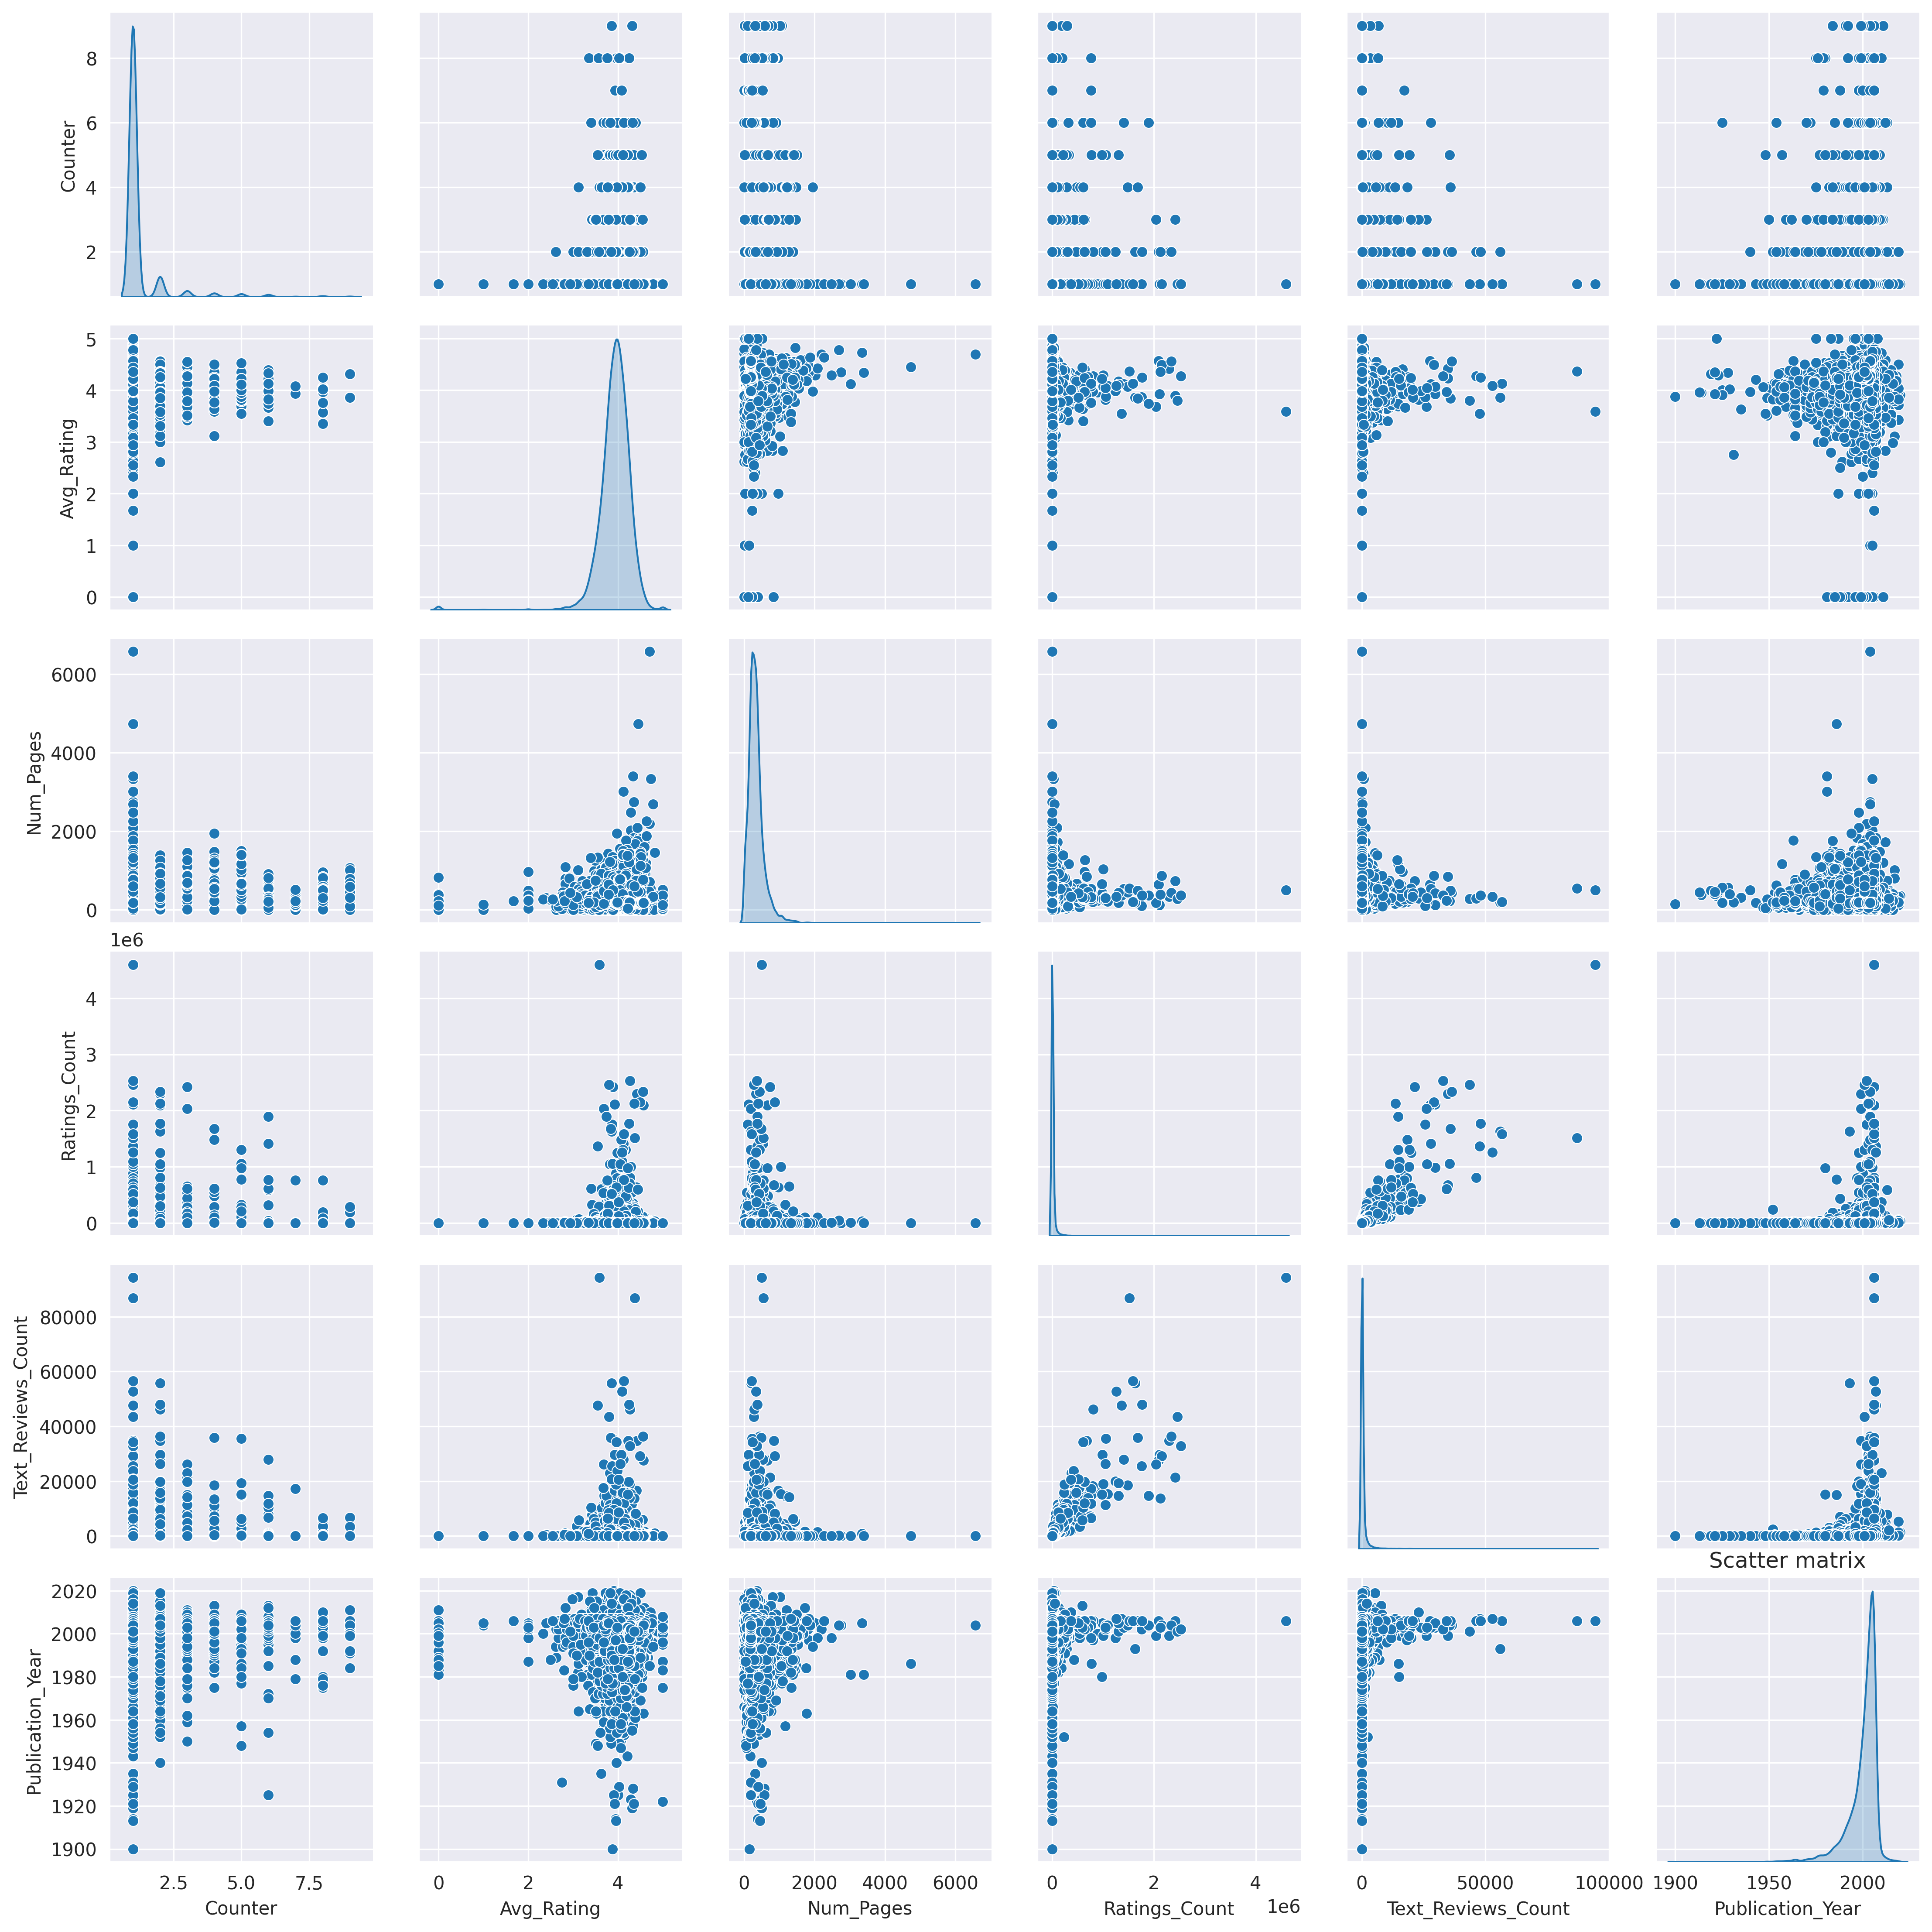

In [6]:
plt.figure()
ax = sns.pairplot(df_encoded[["Counter", "Avg_Rating", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]], diag_kind="kde")
plt.title("Scatter matrix")
ax.fig.set_dpi(300)

### Correlation plot

<Axes: title={'center': 'Correlation Matrix'}>

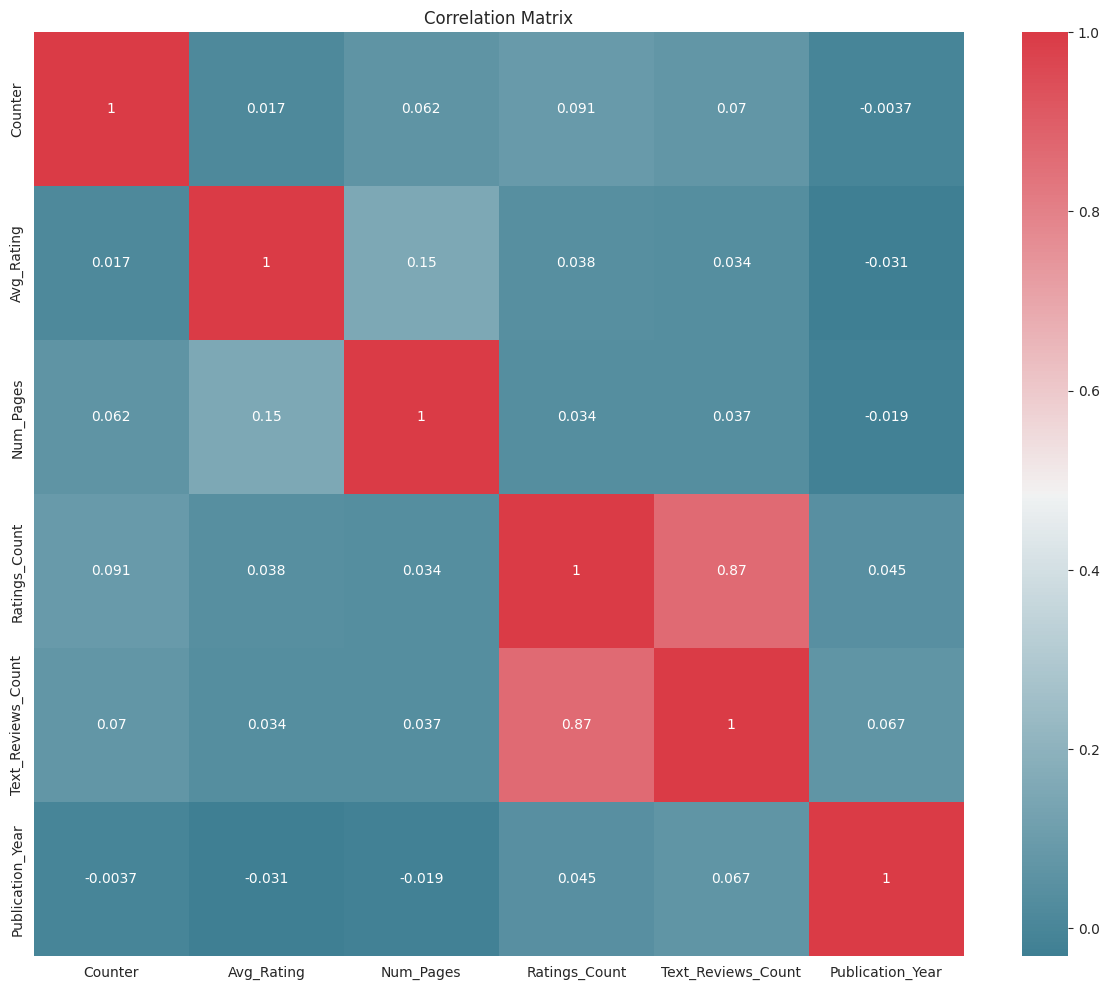

In [7]:
plt.figure(figsize=(15,12))
corr = df_encoded[["Counter", "Avg_Rating", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]].corr()
plt.title("Correlation Matrix")
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)

## Data preparation and standardization

Another crucial step to apply before implementing ML models is to split the dataset into a training and test set and standardize the data.

### Train/Test split

In [8]:
from sklearn.model_selection import train_test_split

feature_matrix = df_encoded.loc[:, df_encoded.columns != 'Avg_Rating']
target_vector = df_encoded.Avg_Rating
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, target_vector, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_test.head()

(8901, 44)
(2226, 44)
(8901,)
(2226,)


,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8,Title_9,...,Publisher_3,Publisher_4,Publisher_5,Publisher_6,Publisher_7,Publisher_8,Publisher_9,Publisher_10,Publisher_11,Publication_Year
9914,1,0,0,0,1,1,1,1,0,0,...,0,0,1,1,0,1,1,0,1,2010.0
4437,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,2004.0
5140,0,1,0,0,1,0,1,0,1,0,...,0,1,1,0,1,1,1,1,1,1998.0
2617,0,0,1,0,0,1,1,0,0,0,...,0,0,1,1,1,0,0,0,1,2006.0
4804,0,1,0,0,0,1,0,1,1,1,...,0,1,0,0,1,0,0,0,0,2002.0


### Standardization

In [9]:
from sklearn.preprocessing import StandardScaler

# Creating an object for StandardScaler
sc = StandardScaler()

# Scaling specific columns
X_train[["Counter", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]] = sc.fit_transform(X_train[["Counter", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]])

X_test[["Counter", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]] = sc.transform(X_test[["Counter", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]])

X_test.head()

,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8,Title_9,...,Publisher_3,Publisher_4,Publisher_5,Publisher_6,Publisher_7,Publisher_8,Publisher_9,Publisher_10,Publisher_11,Publication_Year
9914,1,0,0,0,1,1,1,1,0,0,...,0,0,1,1,0,1,1,0,1,1.210123
4437,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0.467449
5140,0,1,0,0,1,0,1,0,1,0,...,0,1,1,0,1,1,1,1,1,-0.275224
2617,0,0,1,0,0,1,1,0,0,0,...,0,0,1,1,1,0,0,0,1,0.715007
4804,0,1,0,0,0,1,0,1,1,1,...,0,1,0,0,1,0,0,0,0,0.219891


## Models

In this section we applied a variety of machine learning models to test our hypothesis.

### Linear Regression

R2_train:  0.03679633989183129
R2_test:  0.026954669041935553
Mean Squared Error: 0.14797604750346685


<Axes: title={'center': "Coefficient's value"}>

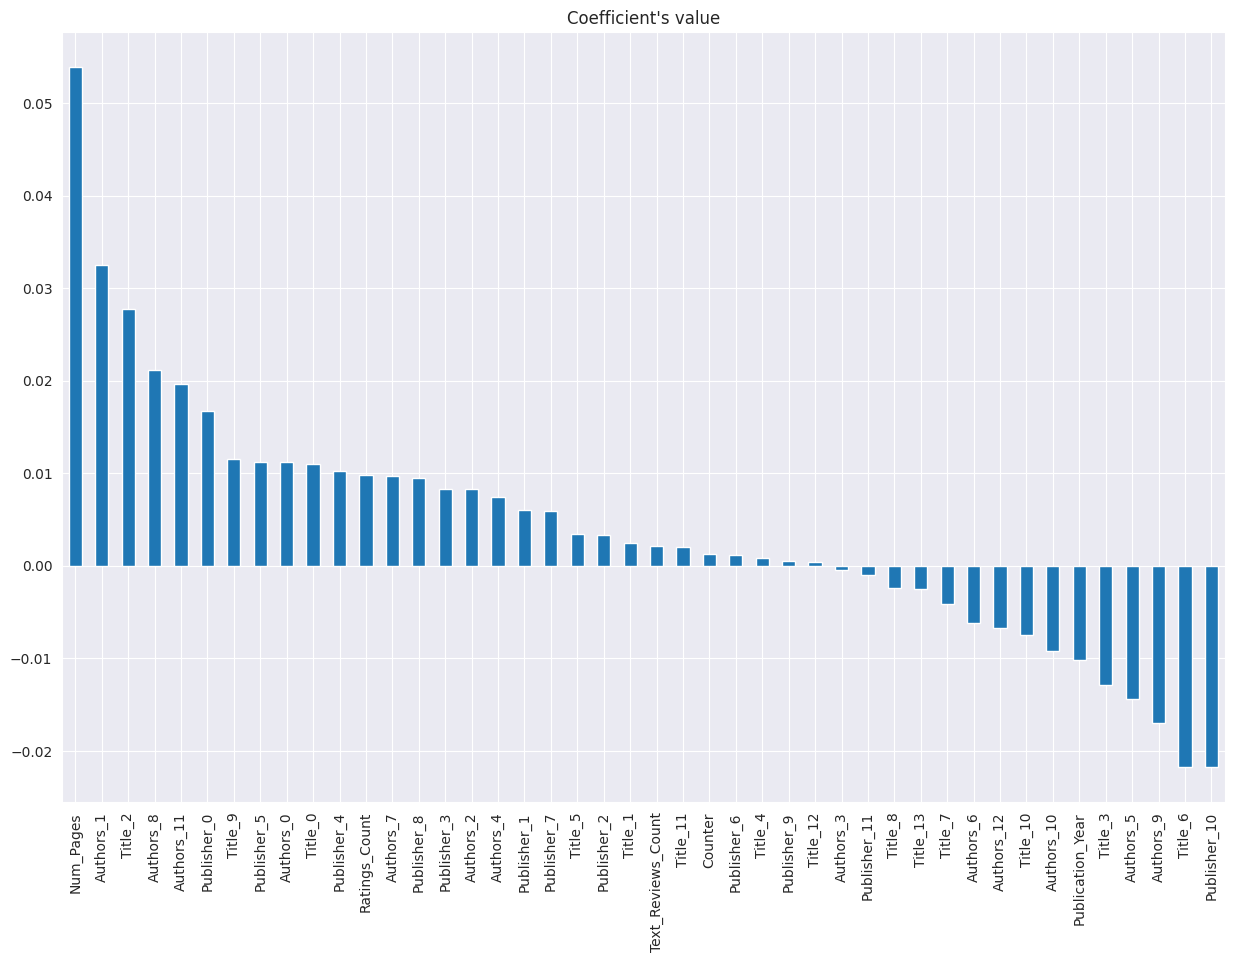

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error

model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

R2_base = metrics.r2_score(y_train, model.predict(X_train), sample_weight=None, multioutput='uniform_average')
R2 = metrics.r2_score(y_test, model.predict(X_test), sample_weight=None, multioutput='uniform_average')
mse = mean_squared_error(y_test, model.predict(X_test))

print("R2_train: ", R2_base)
print("R2_test: ", R2)
print(f'Mean Squared Error: {mse}')

coefficients = pd.Series(model.coef_, index=X_train.columns).sort_values(ascending=False)
coefficients.plot(kind='bar', figsize=(15,10), title="Coefficient's value", grid=True)

### Lasso regression

R2_train:  0.034117446751639524
R2_test:  0.025611446089080725
Mean Squared Error: 0.14818031838084075


<Axes: title={'center': "Coefficient's value"}>

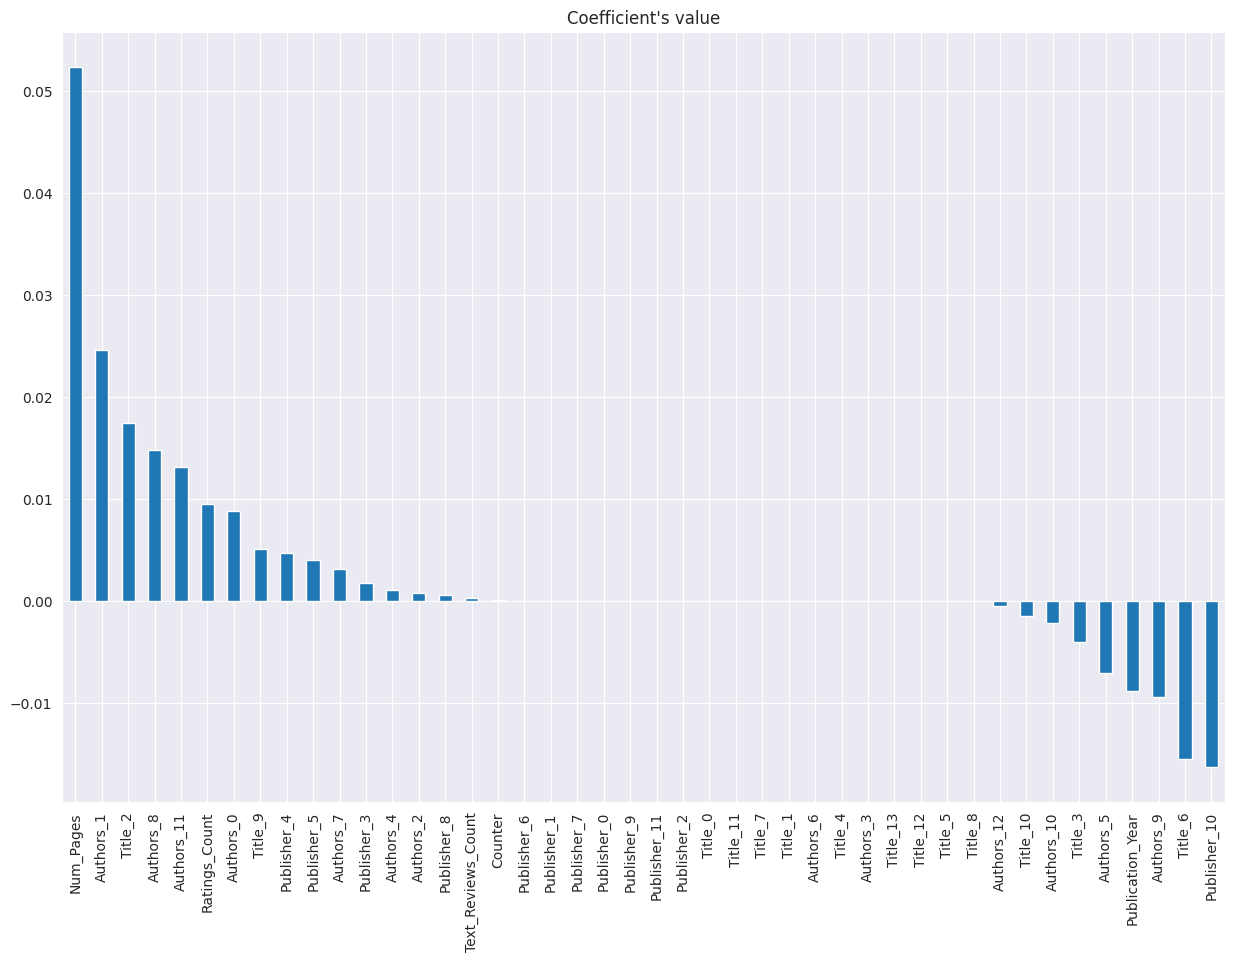

In [11]:
# Lasso
from sklearn.linear_model import LassoCV
from sklearn import metrics

model = LassoCV(fit_intercept=True)
model.fit(X_train, y_train)

R2_base = metrics.r2_score(y_train, model.predict(X_train), sample_weight=None, multioutput='uniform_average')
R2 = metrics.r2_score(y_test, model.predict(X_test), sample_weight=None, multioutput='uniform_average')
mse = mean_squared_error(y_test, model.predict(X_test))

print("R2_train: ", R2_base)
print("R2_test: ", R2)
print(f'Mean Squared Error: {mse}')

coefficients = pd.Series(model.coef_, index=X_train.columns).sort_values(ascending=False)
coefficients.plot(kind='bar', figsize=(15,10), title="Coefficient's value", grid=True)

### Random forest regression

In [12]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=600, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)

R2_base = metrics.r2_score(y_train, regressor.predict(X_train))
R2 = metrics.r2_score(y_test, regressor.predict(X_test))
mse = mean_squared_error(y_test, regressor.predict(X_test))

print("R2_train: ", R2_base)
print("R2_test: ", R2)
print(f'Mean Squared Error: {mse}')

R2_train:  0.8869040178803969
R2_test:  0.13992888218871957
Mean Squared Error: 0.1307954732800489


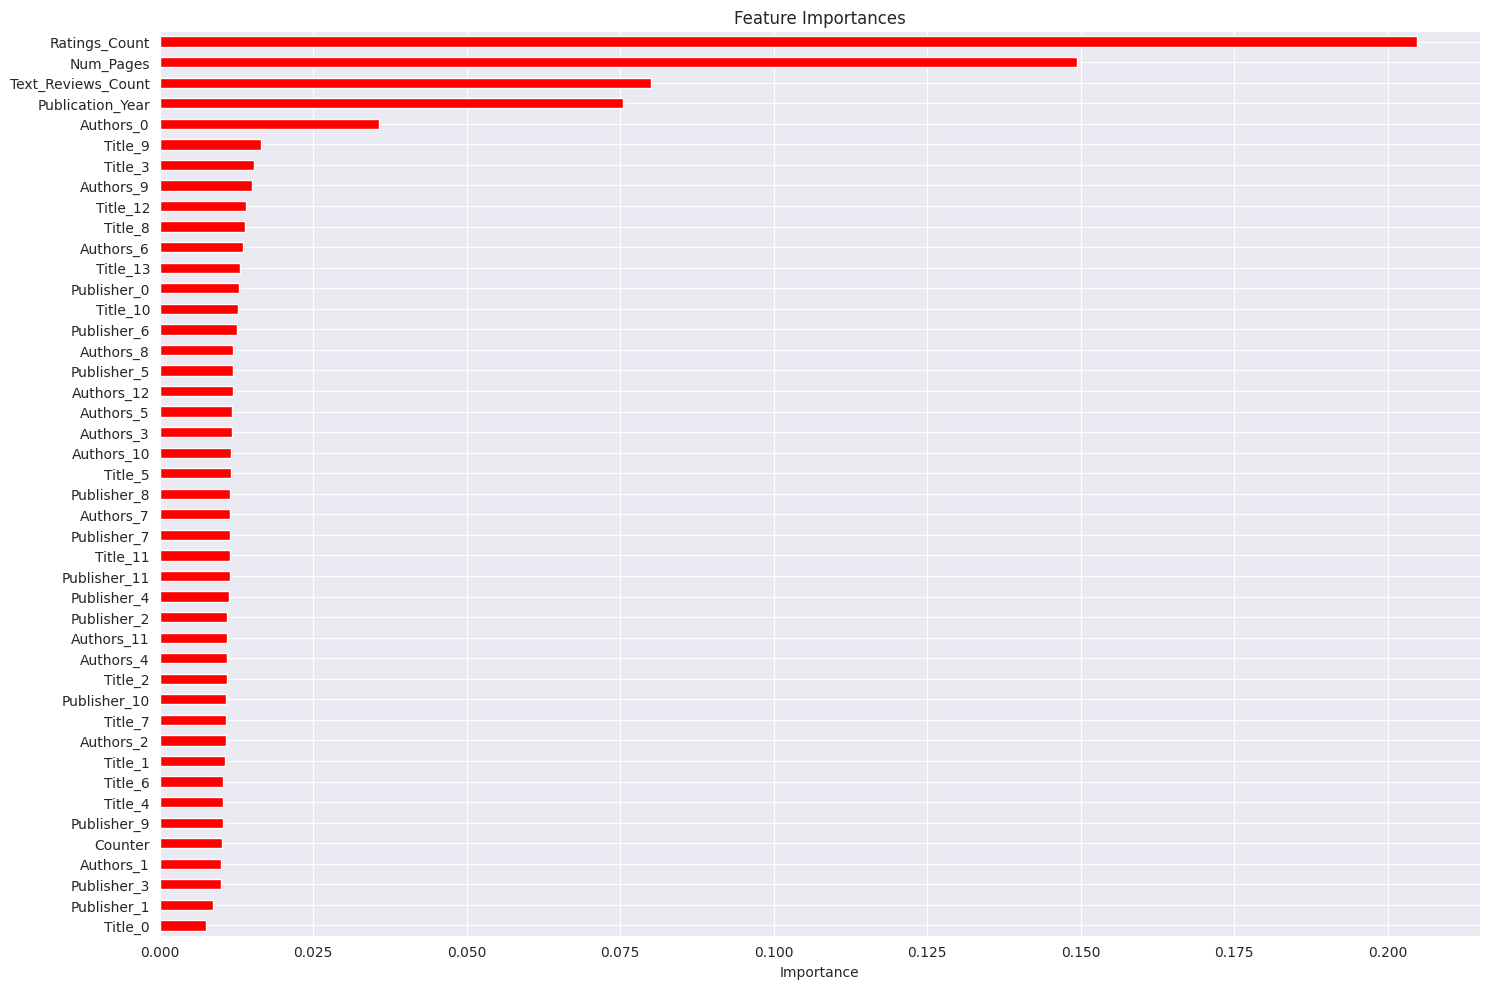

In [13]:
feature_importance = pd.Series(regressor.feature_importances_, index=X_train.columns)
feature_importance.sort_values().plot(kind='barh', figsize=(15, 10), color='r', title='Feature Importances', grid=True, xlabel='Importance')
plt.tight_layout()
plt.show()

### Boosting regression

In [14]:
from sklearn import ensemble

params = {
    "n_estimators": 800,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

regressor = ensemble.GradientBoostingRegressor(**params)
regressor.fit(X_train, y_train)

R2_base = metrics.r2_score(y_train, regressor.predict(X_train))
R2 = metrics.r2_score(y_test, regressor.predict(X_test))
mse = mean_squared_error(y_test, regressor.predict(X_test))

print("R2_train: ", R2_base)
print("R2_test: ", R2)
print(f'Mean Squared Error: {mse}')

R2_train:  0.42180810218306386
R2_test:  0.1093103157353974
Mean Squared Error: 0.13545179739962904


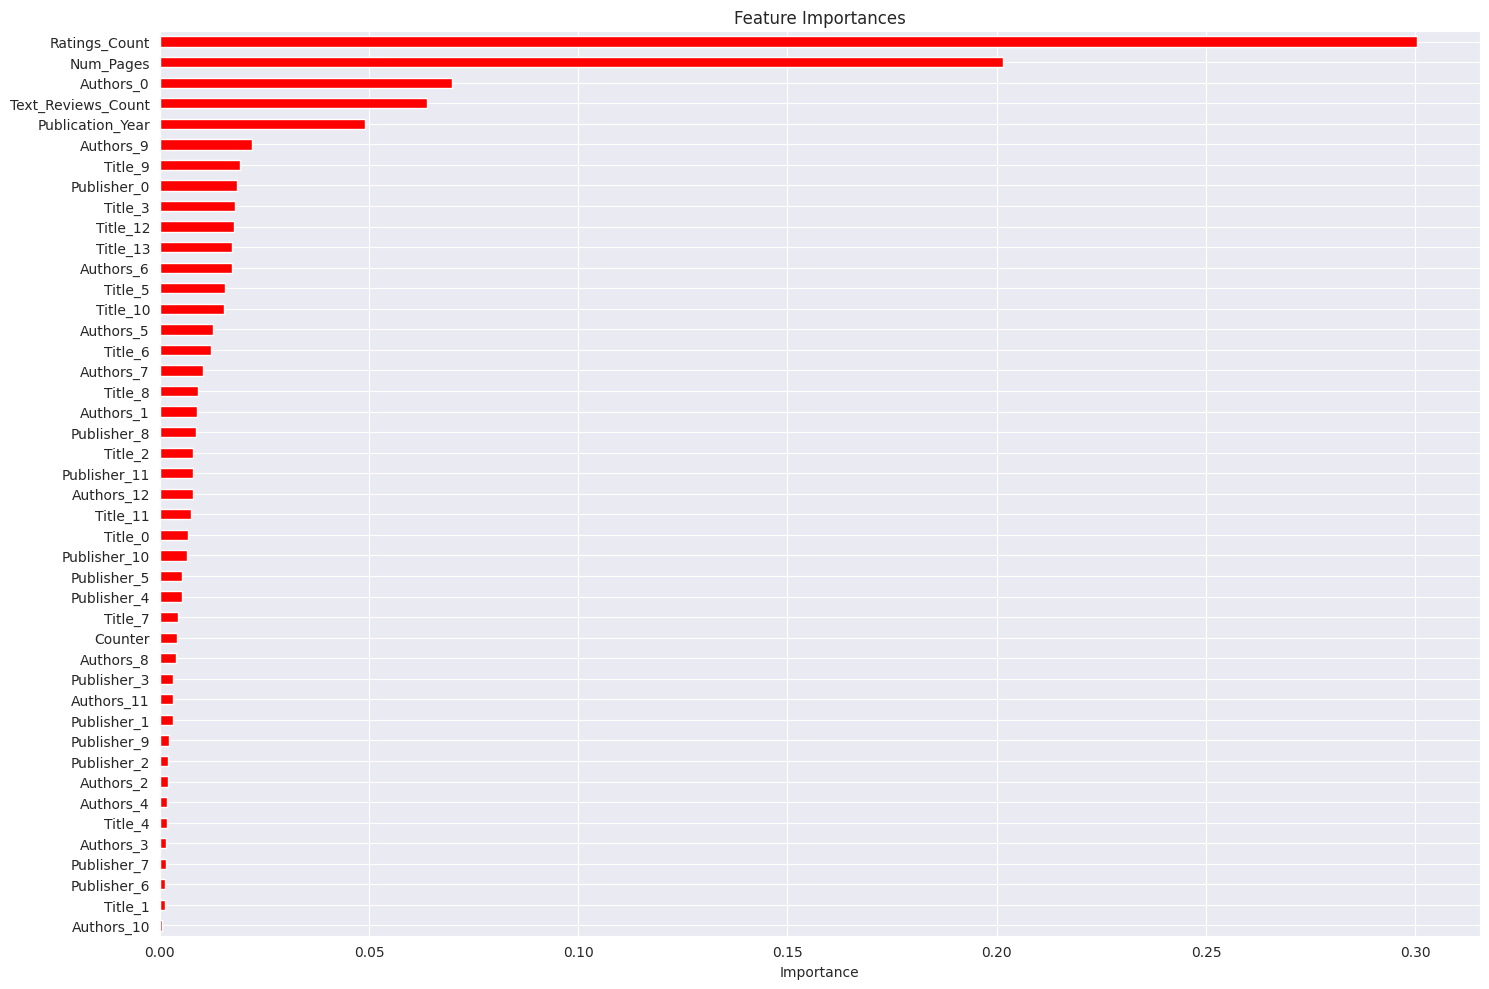

In [15]:
feature_importance = pd.Series(regressor.feature_importances_, index=X_train.columns)
feature_importance.sort_values().plot(kind='barh', figsize=(15, 10), color='r', title='Feature Importances', grid=True, xlabel='Importance')
plt.tight_layout()
plt.show()

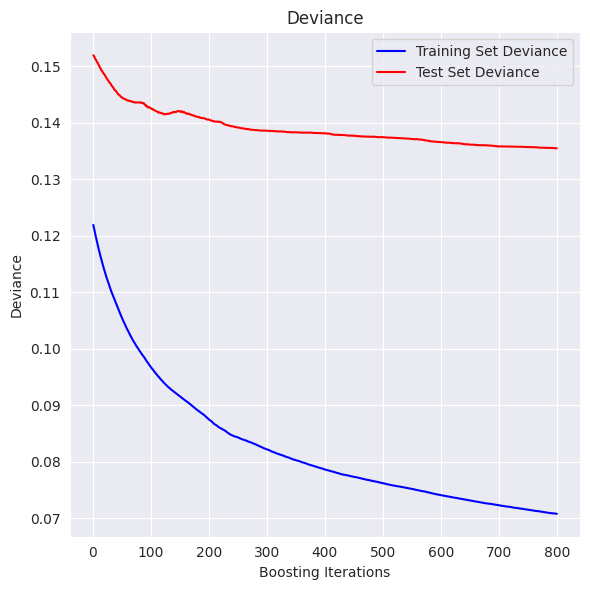

In [16]:
import numpy as np

# Plot showing MSE for training and test for each iteration
test_score = np.zeros((params["n_estimators"]), dtype=np.float64)
for i, y_pred in enumerate(regressor.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.title("Deviance")
plt.plot(np.arange(params["n_estimators"]) + 1, regressor.train_score_, "b-", label="Training Set Deviance")
plt.plot(np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance")

plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Final model

Given the previous results, we concluded that the textual features were not particularly relevant. Hence, we decided to test random forest regression again onyl with numerical features.

In [17]:
df_final = df_encoded[["Avg_Rating", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]]
df_final.head()

,Avg_Rating,Num_Pages,Ratings_Count,Text_Reviews_Count,Publication_Year
0,3.49,528,30,4,2003.0
1,3.85,992,36303,439,2003.0
2,3.90,320,3490,177,2004.0
3,3.91,395,204,19,1985.0
4,4.39,232,12613,392,1986.0


In [18]:
from sklearn.model_selection import train_test_split

feature_matrix = df_final.loc[:, df_final.columns != 'Avg_Rating']
target_vector = df_final.Avg_Rating
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, target_vector, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_test.head()

(8901, 4)
(2226, 4)
(8901,)
(2226,)


,Num_Pages,Ratings_Count,Text_Reviews_Count,Publication_Year
9914,304,34751,1346,2010.0
4437,536,1395,131,2004.0
5140,335,0,0,1998.0
2617,160,18799,568,2006.0
4804,256,213,13,2002.0


In [19]:
# Standardization
from sklearn.preprocessing import  StandardScaler

# Creating an object for StandardScaler
sc = StandardScaler()

# Scaling specific columns
X_train[["Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]] = sc.fit_transform(X_train[["Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]])

X_test[["Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]] = sc.transform(X_test[["Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]])

X_test.head()

,Num_Pages,Ratings_Count,Text_Reviews_Count,Publication_Year
9914,-0.143530,0.140788,0.286226,1.210123
4437,0.798439,-0.143870,-0.156710,0.467449
5140,-0.017664,-0.155775,-0.204467,-0.275224
2617,-0.728201,0.004654,0.002601,0.715007
4804,-0.338420,-0.153958,-0.199728,0.219891


In [20]:
regressor = RandomForestRegressor(n_estimators=600, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)

R2_base = metrics.r2_score(y_train, regressor.predict(X_train))
R2 = metrics.r2_score(y_test, regressor.predict(X_test))
mse = mean_squared_error(y_test, regressor.predict(X_test))

print("R2_train: ", R2_base)
print("R2_test: ", R2)
print(f'Mean Squared Error: {mse}')

R2_train:  0.8778395343319161
R2_test:  0.20160157871493334
Mean Squared Error: 0.1214165866234074


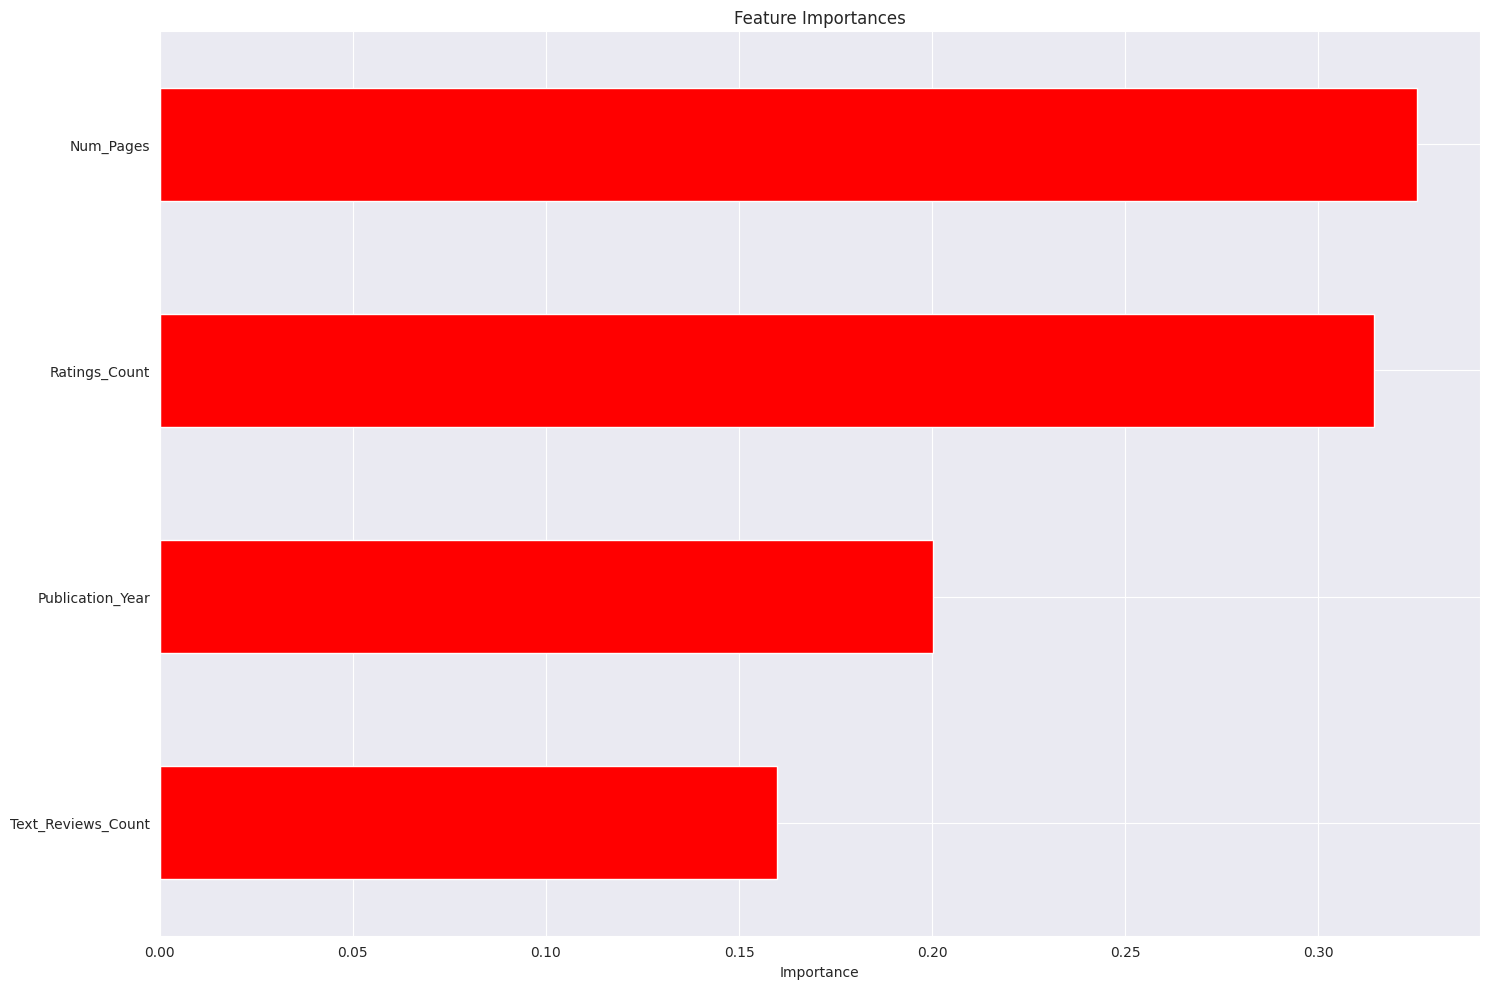

In [21]:
feature_importance = pd.Series(regressor.feature_importances_, index=X_train.columns)
feature_importance.sort_values().plot(kind='barh', figsize=(15, 10), color='r', title='Feature Importances', grid=True, xlabel='Importance')
plt.tight_layout()
plt.show()

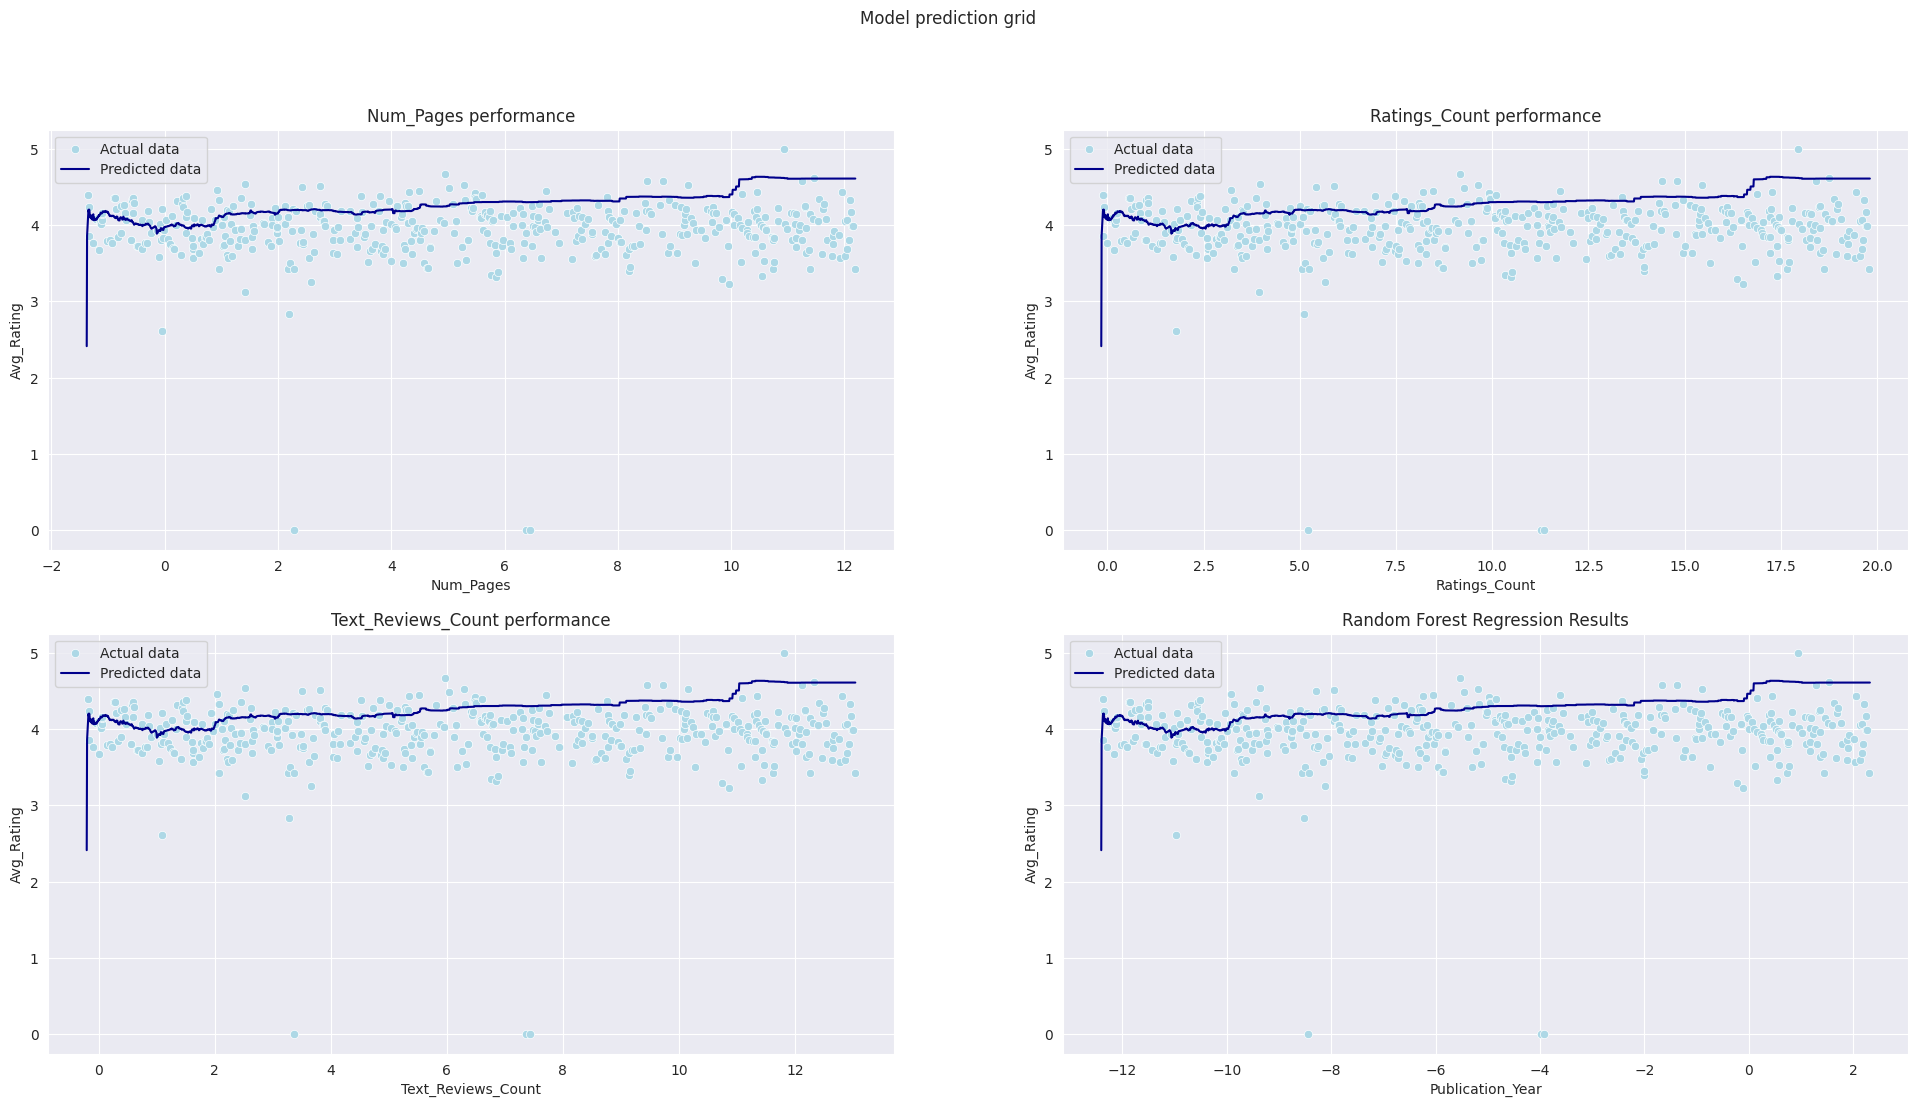

In [22]:
import numpy as np

rating_col=pd.Series(np.linspace(start=min(X_test["Ratings_Count"]), stop=max(X_test["Ratings_Count"]), num=y_test.shape[0]))
num_page=pd.Series(np.linspace(start=min(X_test["Num_Pages"]), stop=max(X_test["Num_Pages"]), num=y_test.shape[0]))
text_review=pd.Series(np.linspace(start=min(X_test["Text_Reviews_Count"]), stop=max(X_test["Text_Reviews_Count"]), num=y_test.shape[0]))
publ_year=pd.Series(np.linspace(start=min(X_test["Publication_Year"]), stop=max(X_test["Publication_Year"]), num=y_test.shape[0]))

frame={
  "Num_Pages": num_page,
  "Ratings_Count": rating_col,
  "Text_Reviews_Count": text_review,
  "Publication_Year": publ_year,
}

df_grid=pd.DataFrame(frame)
df_grid["Predictions"] = regressor.predict(df_grid)
df_grid["Avg_Rating"] = y_test

fig, axes = plt.subplots(2, 2, figsize=(24, 12))
fig.suptitle("Model prediction grid")

axes[0, 0].set(title="Num_Pages performance")
sns.scatterplot(ax=axes[0, 0], data=df_grid, x="Num_Pages", y="Avg_Rating", label="Actual data", color="lightblue")
sns.lineplot(ax=axes[0, 0], data=df_grid, x="Num_Pages", y="Predictions", color="darkblue", label="Predicted data")
plt.title("Random Forest Regression Results")
plt.xlabel('Num_Pages')
plt.ylabel('Avg_Rating')

axes[0, 1].set(title="Ratings_Count performance")
sns.scatterplot(ax=axes[0, 1], data=df_grid, x="Ratings_Count", y="Avg_Rating", label="Actual data", color="lightblue")
sns.lineplot(ax=axes[0, 1], data=df_grid, x="Ratings_Count", y="Predictions", color="darkblue", label="Predicted data")
plt.title("Random Forest Regression Results")
plt.xlabel('Ratings_Count')
plt.ylabel('Avg_Rating')

axes[1, 0].set(title="Text_Reviews_Count performance")
sns.scatterplot(ax=axes[1, 0], data=df_grid, x="Text_Reviews_Count", y="Avg_Rating", label="Actual data", color="lightblue")
sns.lineplot(ax=axes[1, 0], data=df_grid, x="Text_Reviews_Count", y="Predictions", color="darkblue", label="Predicted data")
plt.title("Random Forest Regression Results")
plt.xlabel('Text_Reviews_Count')
plt.ylabel('Avg_Rating')

axes[1, 1].set(title="Publication_Year performance")
sns.scatterplot(ax=axes[1, 1], data=df_grid, x="Publication_Year", y="Avg_Rating", label="Actual data", color="lightblue")
sns.lineplot(ax=axes[1, 1], data=df_grid, x="Publication_Year", y="Predictions", color="darkblue", label="Predicted data")
plt.title("Random Forest Regression Results")
plt.xlabel('Publication_Year')
plt.ylabel('Avg_Rating')

plt.show()